# Water Quality Prediction

### Challenge Overview
Welcome to the EY AI & Data Challenge 2026! The objective of this challenge is to build a robust machine learning model capable of predicting water quality across various river locations in South Africa. In addition to accurate predictions, the model should also identify and emphasize the key factors that significantly influence water quality.

Participants will be provided with a dataset containing three water quality parameters Total Alkalinity, Electrical Conductance, and Dissolved Reactive Phosphorus collected between 2011 and 2015 from approximately 200 river locations across South Africa. Each data point includes the geographic coordinates (latitude and longitude) of the sampling site, the date of collection, and the corresponding water quality measurements.

Using this dataset, participants are expected to build a machine learning model to predict water quality parameters for a separate validation dataset, which includes locations from different regions not present in the training data. The challenge also encourages participants to explore feature importance and provide insights into the factors most strongly associated with variations in water quality.

This challenge is designed for participants with varying levels of experience in data science, remote sensing, and environmental analytics. It offers a valuable opportunity to apply machine learning techniques to real-world environmental data and contribute to advancing water quality monitoring using artificial intelligence.

In [97]:
# %pip install --force-reinstall shap

In [98]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
# import shap

import warnings



from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

warnings.filterwarnings("ignore")

### Load Datasets

In [99]:
water_quality_df = pd.read_csv("water_quality_training_dataset.csv")

# landsat datasets
landsat_training_df = pd.read_csv("landsat_features_training.csv")
landsat_validation_df = pd.read_csv("landsat_features_validation.csv")

# terraclimate datasets
terraclimate_training_df = pd.read_csv("terraclimate_features_training.csv")
terraclimate_validation_df = pd.read_csv("terraclimate_features_validation.csv")

In [100]:
water_quality_df.head()

,Latitude,Longitude,Sample Date,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus
0,-28.760833,17.730278,02-01-2011,128.912,555.0,10.0
1,-26.861111,28.884722,03-01-2011,74.720,162.9,163.0
2,-26.450000,28.085833,03-01-2011,89.254,573.0,80.0
3,-27.671111,27.236944,03-01-2011,82.000,203.6,101.0
4,-27.356667,27.286389,03-01-2011,56.100,145.1,151.0


In [101]:
landsat_training_df.head()

,Latitude,Longitude,Sample Date,nir,green,swir16,swir22,NDMI,MNDWI
0,-28.760833,17.730278,02-01-2011,11190.0,11426.0,7687.5,7645.0,0.185538,0.195595
1,-26.861111,28.884722,03-01-2011,17658.5,9550.0,13746.5,10574.0,0.124566,-0.180134
2,-26.450000,28.085833,03-01-2011,15210.0,10720.0,17974.0,14201.0,-0.083293,-0.252805
3,-27.671111,27.236944,03-01-2011,14887.0,10943.0,13522.0,11403.0,0.048048,-0.105416
4,-27.356667,27.286389,03-01-2011,16828.5,9502.5,12665.5,9643.0,0.141147,-0.142683


In [102]:
landsat_validation_df.head()

,Latitude,Longitude,Sample Date,nir,green,swir16,swir22,NDMI,MNDWI
0,-32.043333,27.822778,01-09-2014,15229.0,12868.0,14797.0,12421.0,0.014388,-0.069727
1,-33.329167,26.077500,16-09-2015,NaN,NaN,NaN,NaN,NaN,NaN
2,-32.991639,27.640028,07-05-2015,16221.0,9304.5,12536.5,9958.0,0.128123,-0.147979
3,-34.096389,24.439167,07-02-2012,NaN,NaN,NaN,NaN,NaN,NaN
4,-32.000556,28.581667,01-10-2014,9125.0,11100.5,9455.0,8711.0,-0.017761,0.080052


In [103]:
terraclimate_training_df.head()

,Latitude,Longitude,Sample Date,pet
0,-28.760833,17.730278,02-01-2011,174.2
1,-26.861111,28.884722,03-01-2011,124.1
2,-26.450000,28.085833,03-01-2011,127.5
3,-27.671111,27.236944,03-01-2011,129.7
4,-27.356667,27.286389,03-01-2011,129.2


In [104]:
terraclimate_validation_df.head()

,Latitude,Longitude,Sample Date,pet
0,-32.043333,27.822778,01-09-2014,161.90001
1,-33.329167,26.077500,16-09-2015,177.60000
2,-32.991639,27.640028,07-05-2015,158.40001
3,-34.096389,24.439167,07-02-2012,130.00000
4,-32.000556,28.581667,01-10-2014,152.50000


In [105]:
def check_for_missing_values():
    datasets = [
        water_quality_df, 
        landsat_training_df, 
         landsat_validation_df, 
        terraclimate_validation_df,
        terraclimate_training_df
    ]
    for i, k in enumerate(datasets):
        print()
        print(k.isnull().sum())
        print("\n")
        print("")
        

In [106]:
water_quality_df.isnull().sum()

Latitude                         0
Longitude                        0
Sample Date                      0
Total Alkalinity                 0
Electrical Conductance           0
Dissolved Reactive Phosphorus    0
dtype: int64

In [107]:
check_for_missing_values()


Latitude                         0
Longitude                        0
Sample Date                      0
Total Alkalinity                 0
Electrical Conductance           0
Dissolved Reactive Phosphorus    0
dtype: int64




Latitude          0
Longitude         0
Sample Date       0
nir            1085
green          1085
swir16         1085
swir22         1085
NDMI           1085
MNDWI          1085
dtype: int64




Latitude        0
Longitude       0
Sample Date     0
nir            19
green          19
swir16         19
swir22         19
NDMI           19
MNDWI          19
dtype: int64




Latitude       0
Longitude      0
Sample Date    0
pet            0
dtype: int64




Latitude       0
Longitude      0
Sample Date    0
pet            0
dtype: int64





In [108]:
landsat_training_df.isnull().mean()*100

Latitude        0.00000
Longitude       0.00000
Sample Date     0.00000
nir            11.64288
green          11.64288
swir16         11.64288
swir22         11.64288
NDMI           11.64288
MNDWI          11.64288
dtype: float64

In [109]:
landsat_validation_df.isnull().mean()*100

Latitude       0.0
Longitude      0.0
Sample Date    0.0
nir            9.5
green          9.5
swir16         9.5
swir22         9.5
NDMI           9.5
MNDWI          9.5
dtype: float64

In [110]:
landsat_training_df["landsat_missing"] = (
    landsat_training_df[["nir", "green", "swir16", "swir22"]]
    .isna()
    .any(axis=1)
)


In [111]:
landsat_training_df.isnull().mean()*100

Latitude            0.00000
Longitude           0.00000
Sample Date         0.00000
nir                11.64288
green              11.64288
swir16             11.64288
swir22             11.64288
NDMI               11.64288
MNDWI              11.64288
landsat_missing     0.00000
dtype: float64

In [112]:
landsat_validation_df["landsat_missing"] = (
    landsat_validation_df[["nir", "green", "swir16", "swir22"]]
    .isna()
    .any(axis=1)
)


In [113]:
landsat_validation_df.isnull().mean()*100

Latitude           0.0
Longitude          0.0
Sample Date        0.0
nir                9.5
green              9.5
swir16             9.5
swir22             9.5
NDMI               9.5
MNDWI              9.5
landsat_missing    0.0
dtype: float64

In [114]:
water_quality_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 9319 entries, 0 to 9318
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Latitude                       9319 non-null   float64
 1   Longitude                      9319 non-null   float64
 2   Sample Date                    9319 non-null   str    
 3   Total Alkalinity               9319 non-null   float64
 4   Electrical Conductance         9319 non-null   float64
 5   Dissolved Reactive Phosphorus  9319 non-null   float64
dtypes: float64(5), str(1)
memory usage: 528.0 KB


In [115]:
landsat_training_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 9319 entries, 0 to 9318
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Latitude         9319 non-null   float64
 1   Longitude        9319 non-null   float64
 2   Sample Date      9319 non-null   str    
 3   nir              8234 non-null   float64
 4   green            8234 non-null   float64
 5   swir16           8234 non-null   float64
 6   swir22           8234 non-null   float64
 7   NDMI             8234 non-null   float64
 8   MNDWI            8234 non-null   float64
 9   landsat_missing  9319 non-null   bool   
dtypes: bool(1), float64(8), str(1)
memory usage: 755.5 KB


In [116]:
landsat_validation_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Latitude         200 non-null    float64
 1   Longitude        200 non-null    float64
 2   Sample Date      200 non-null    str    
 3   nir              181 non-null    float64
 4   green            181 non-null    float64
 5   swir16           181 non-null    float64
 6   swir22           181 non-null    float64
 7   NDMI             181 non-null    float64
 8   MNDWI            181 non-null    float64
 9   landsat_missing  200 non-null    bool   
dtypes: bool(1), float64(8), str(1)
memory usage: 16.3 KB


In [117]:
terraclimate_training_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 9319 entries, 0 to 9318
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Latitude     9319 non-null   float64
 1   Longitude    9319 non-null   float64
 2   Sample Date  9319 non-null   str    
 3   pet          9319 non-null   float64
dtypes: float64(3), str(1)
memory usage: 382.4 KB


In [118]:
terraclimate_validation_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Latitude     200 non-null    float64
 1   Longitude    200 non-null    float64
 2   Sample Date  200 non-null    str    
 3   pet          200 non-null    float64
dtypes: float64(3), str(1)
memory usage: 8.3 KB


In [119]:
def convert_sample_date_to_datetime():
    datasets = [
        water_quality_df, 
        landsat_training_df, 
         landsat_validation_df,
        terraclimate_training_df,
        terraclimate_validation_df
    ]
    
    for i in datasets:
        i['Sample Date'] = pd.to_datetime(i["Sample Date"], format="%d-%m-%Y")

    return i

In [120]:
convert_sample_date_to_datetime().head()

,Latitude,Longitude,Sample Date,pet
0,-32.043333,27.822778,2014-09-01,161.90001
1,-33.329167,26.077500,2015-09-16,177.60000
2,-32.991639,27.640028,2015-05-07,158.40001
3,-34.096389,24.439167,2012-02-07,130.00000
4,-32.000556,28.581667,2014-10-01,152.50000


In [121]:
water_quality_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 9319 entries, 0 to 9318
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Latitude                       9319 non-null   float64       
 1   Longitude                      9319 non-null   float64       
 2   Sample Date                    9319 non-null   datetime64[us]
 3   Total Alkalinity               9319 non-null   float64       
 4   Electrical Conductance         9319 non-null   float64       
 5   Dissolved Reactive Phosphorus  9319 non-null   float64       
dtypes: datetime64[us](1), float64(5)
memory usage: 437.0 KB


In [122]:
terraclimate_validation_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Latitude     200 non-null    float64       
 1   Longitude    200 non-null    float64       
 2   Sample Date  200 non-null    datetime64[us]
 3   pet          200 non-null    float64       
dtypes: datetime64[us](1), float64(3)
memory usage: 6.4 KB


In [123]:
water_quality_df.duplicated(subset=["Sample Date", "Latitude", "Longitude"]).sum()

np.int64(0)

In [124]:
def check_duplicated_series():
    datasets = [
        water_quality_df, 
        landsat_training_df, 
         landsat_validation_df,
        terraclimate_training_df,
        terraclimate_validation_df
    ]

    for i in datasets:
        print(i.duplicated(subset=["Sample Date", "Latitude", "Longitude"]).sum())

In [125]:
check_duplicated_series()

0
0
0
0
0


In [126]:
def clean_columns(df):
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
    )
    return df

In [127]:
water_quality_df = clean_columns(water_quality_df)
landsat_training_df = clean_columns(landsat_training_df)
landsat_validation_df = clean_columns(landsat_validation_df)
terraclimate_training_df = clean_columns(terraclimate_training_df)
terraclimate_validation_df = clean_columns(terraclimate_validation_df)

In [128]:
water_quality_df.head()

,latitude,longitude,sample_date,total_alkalinity,electrical_conductance,dissolved_reactive_phosphorus
0,-28.760833,17.730278,2011-01-02,128.912,555.0,10.0
1,-26.861111,28.884722,2011-01-03,74.720,162.9,163.0
2,-26.450000,28.085833,2011-01-03,89.254,573.0,80.0
3,-27.671111,27.236944,2011-01-03,82.000,203.6,101.0
4,-27.356667,27.286389,2011-01-03,56.100,145.1,151.0


In [129]:
targets = [
    "total_alkalinity",
    "electrical_conductance",
    "dissolved_reactive_phosphorus"
]

water_quality_df[targets].describe().T


,count,mean,std,min,25%,50%,75%,max
total_alkalinity,9319.0,119.108208,74.692591,4.80,55.811,113.3,170.23,361.676
electrical_conductance,9319.0,485.004146,341.937736,15.12,207.050,402.0,693.00,1506.000
dissolved_reactive_phosphorus,9319.0,43.525338,50.980194,5.00,10.000,20.0,48.00,195.000


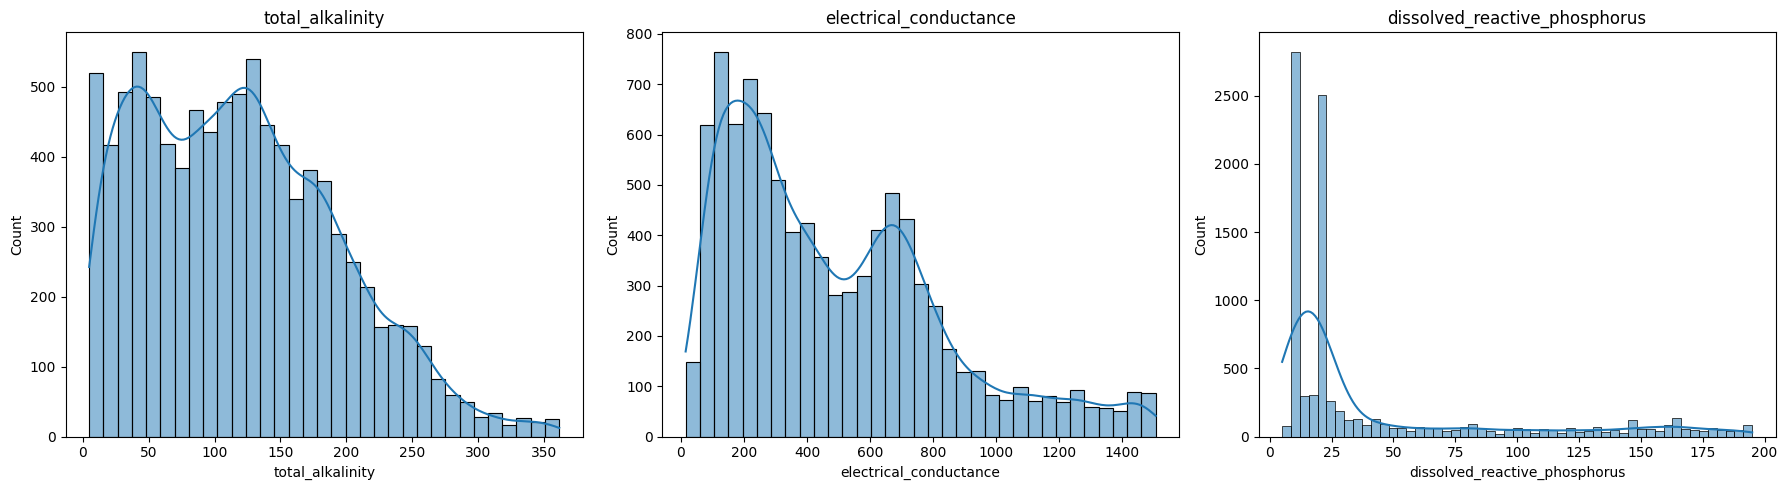

In [130]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, target in zip(axes, targets):
    sb.histplot(water_quality_df[target], kde=True, ax=ax)
    ax.set_title(target)

plt.tight_layout()


Text(0.5, 1.0, 'Pearsons Correlation of Target columns in \nWater Quality Dataset')

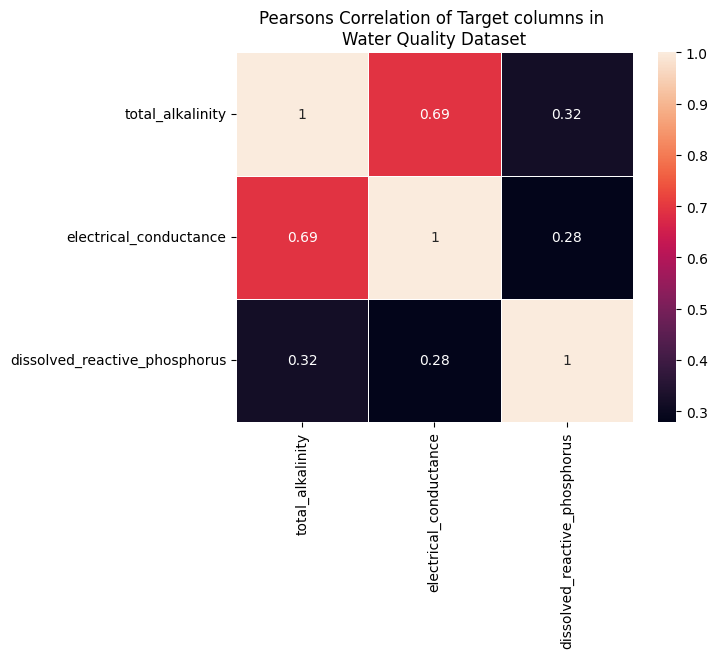

In [131]:
sb.heatmap(water_quality_df[targets].corr(method="pearson"), annot=True, linewidths=0.5)
plt.title("Pearsons Correlation of Target columns in \nWater Quality Dataset", fontdict={'size': 12})

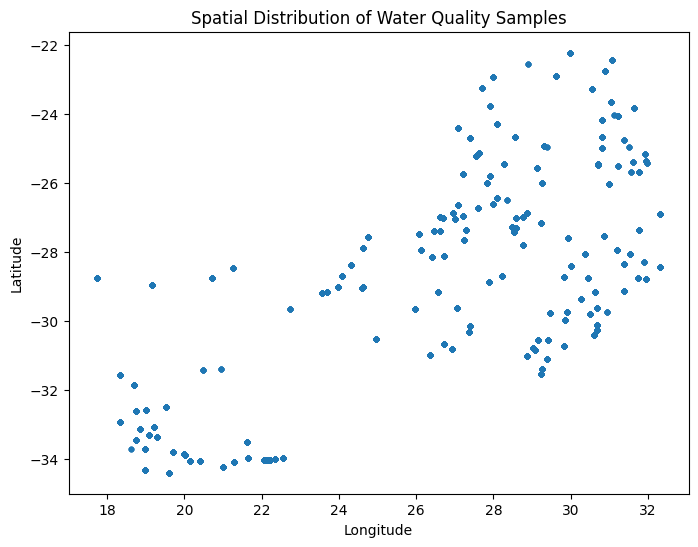

In [132]:
plt.figure(figsize=(8, 6))
plt.scatter(
    water_quality_df["longitude"],
    water_quality_df["latitude"],
    s=10,
    alpha=0.6
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Distribution of Water Quality Samples")
plt.show()


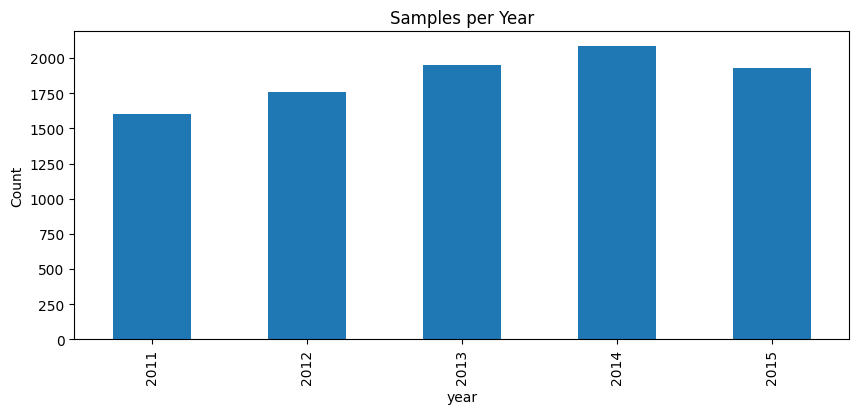

In [133]:
water_quality_df["year"] = water_quality_df["sample_date"].dt.year

water_quality_df["year"].value_counts().sort_index().plot(
    kind="bar", figsize=(10, 4)
)
plt.title("Samples per Year")
plt.ylabel("Count")
plt.show()


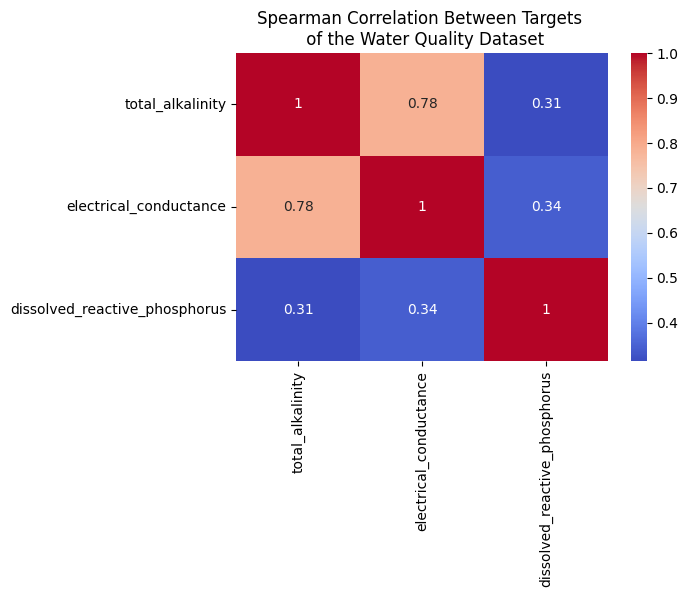

In [134]:
corr = water_quality_df[targets].corr(method="spearman")

plt.figure(figsize=(6, 4))
sb.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Spearman Correlation Between Targets \n of the Water Quality Dataset")
plt.show()


### Feature Engineering

In [135]:
df = water_quality_df.merge(
    landsat_training_df,
    on=["latitude", "longitude", "sample_date"],
    how="left"
)

df = df.merge(
    terraclimate_training_df,
    on=["latitude", "longitude", "sample_date"],
    how="left"
)


In [136]:
df.head()

,latitude,longitude,sample_date,total_alkalinity,electrical_conductance,dissolved_reactive_phosphorus,year,nir,green,swir16,swir22,ndmi,mndwi,landsat_missing,pet
0,-28.760833,17.730278,2011-01-02,128.912,555.0,10.0,2011,11190.0,11426.0,7687.5,7645.0,0.185538,0.195595,False,174.2
1,-26.861111,28.884722,2011-01-03,74.720,162.9,163.0,2011,17658.5,9550.0,13746.5,10574.0,0.124566,-0.180134,False,124.1
2,-26.450000,28.085833,2011-01-03,89.254,573.0,80.0,2011,15210.0,10720.0,17974.0,14201.0,-0.083293,-0.252805,False,127.5
3,-27.671111,27.236944,2011-01-03,82.000,203.6,101.0,2011,14887.0,10943.0,13522.0,11403.0,0.048048,-0.105416,False,129.7
4,-27.356667,27.286389,2011-01-03,56.100,145.1,151.0,2011,16828.5,9502.5,12665.5,9643.0,0.141147,-0.142683,False,129.2


In [137]:
df.shape

(9319, 15)

In [138]:
df.isnull().sum()

latitude                            0
longitude                           0
sample_date                         0
total_alkalinity                    0
electrical_conductance              0
dissolved_reactive_phosphorus       0
year                                0
nir                              1085
green                            1085
swir16                           1085
swir22                           1085
ndmi                             1085
mndwi                            1085
landsat_missing                     0
pet                                 0
dtype: int64

In [139]:
df["year"] = df["sample_date"].dt.year
df["month"] = df["sample_date"].dt.month
df["day_of_year"] = df["sample_date"].dt.dayofyear


In [140]:
df.head()

,latitude,longitude,sample_date,total_alkalinity,electrical_conductance,dissolved_reactive_phosphorus,year,nir,green,swir16,swir22,ndmi,mndwi,landsat_missing,pet,month,day_of_year
0,-28.760833,17.730278,2011-01-02,128.912,555.0,10.0,2011,11190.0,11426.0,7687.5,7645.0,0.185538,0.195595,False,174.2,1,2
1,-26.861111,28.884722,2011-01-03,74.720,162.9,163.0,2011,17658.5,9550.0,13746.5,10574.0,0.124566,-0.180134,False,124.1,1,3
2,-26.450000,28.085833,2011-01-03,89.254,573.0,80.0,2011,15210.0,10720.0,17974.0,14201.0,-0.083293,-0.252805,False,127.5,1,3
3,-27.671111,27.236944,2011-01-03,82.000,203.6,101.0,2011,14887.0,10943.0,13522.0,11403.0,0.048048,-0.105416,False,129.7,1,3
4,-27.356667,27.286389,2011-01-03,56.100,145.1,151.0,2011,16828.5,9502.5,12665.5,9643.0,0.141147,-0.142683,False,129.2,1,3


In [141]:
df["is_wet_season"] = df["month"].isin([10, 11, 12, 1, 2, 3]).astype(int)


In [142]:
df.head()

,latitude,longitude,sample_date,total_alkalinity,electrical_conductance,dissolved_reactive_phosphorus,year,nir,green,swir16,swir22,ndmi,mndwi,landsat_missing,pet,month,day_of_year,is_wet_season
0,-28.760833,17.730278,2011-01-02,128.912,555.0,10.0,2011,11190.0,11426.0,7687.5,7645.0,0.185538,0.195595,False,174.2,1,2,1
1,-26.861111,28.884722,2011-01-03,74.720,162.9,163.0,2011,17658.5,9550.0,13746.5,10574.0,0.124566,-0.180134,False,124.1,1,3,1
2,-26.450000,28.085833,2011-01-03,89.254,573.0,80.0,2011,15210.0,10720.0,17974.0,14201.0,-0.083293,-0.252805,False,127.5,1,3,1
3,-27.671111,27.236944,2011-01-03,82.000,203.6,101.0,2011,14887.0,10943.0,13522.0,11403.0,0.048048,-0.105416,False,129.7,1,3,1
4,-27.356667,27.286389,2011-01-03,56.100,145.1,151.0,2011,16828.5,9502.5,12665.5,9643.0,0.141147,-0.142683,False,129.2,1,3,1


In [143]:
df["is_wet_season"].value_counts()

is_wet_season
0    4868
1    4451
Name: count, dtype: int64

In [144]:

df2 = df.copy()

df2["season"] = df2["is_wet_season"].map({1: "wet", 0: "dry"})

In [145]:
df2.head()

,latitude,longitude,sample_date,total_alkalinity,electrical_conductance,dissolved_reactive_phosphorus,year,nir,green,swir16,swir22,ndmi,mndwi,landsat_missing,pet,month,day_of_year,is_wet_season,season
0,-28.760833,17.730278,2011-01-02,128.912,555.0,10.0,2011,11190.0,11426.0,7687.5,7645.0,0.185538,0.195595,False,174.2,1,2,1,wet
1,-26.861111,28.884722,2011-01-03,74.720,162.9,163.0,2011,17658.5,9550.0,13746.5,10574.0,0.124566,-0.180134,False,124.1,1,3,1,wet
2,-26.450000,28.085833,2011-01-03,89.254,573.0,80.0,2011,15210.0,10720.0,17974.0,14201.0,-0.083293,-0.252805,False,127.5,1,3,1,wet
3,-27.671111,27.236944,2011-01-03,82.000,203.6,101.0,2011,14887.0,10943.0,13522.0,11403.0,0.048048,-0.105416,False,129.7,1,3,1,wet
4,-27.356667,27.286389,2011-01-03,56.100,145.1,151.0,2011,16828.5,9502.5,12665.5,9643.0,0.141147,-0.142683,False,129.2,1,3,1,wet


In [146]:
df2["season"].value_counts()

season
dry    4868
wet    4451
Name: count, dtype: int64

In [147]:
df.head()

,latitude,longitude,sample_date,total_alkalinity,electrical_conductance,dissolved_reactive_phosphorus,year,nir,green,swir16,swir22,ndmi,mndwi,landsat_missing,pet,month,day_of_year,is_wet_season
0,-28.760833,17.730278,2011-01-02,128.912,555.0,10.0,2011,11190.0,11426.0,7687.5,7645.0,0.185538,0.195595,False,174.2,1,2,1
1,-26.861111,28.884722,2011-01-03,74.720,162.9,163.0,2011,17658.5,9550.0,13746.5,10574.0,0.124566,-0.180134,False,124.1,1,3,1
2,-26.450000,28.085833,2011-01-03,89.254,573.0,80.0,2011,15210.0,10720.0,17974.0,14201.0,-0.083293,-0.252805,False,127.5,1,3,1
3,-27.671111,27.236944,2011-01-03,82.000,203.6,101.0,2011,14887.0,10943.0,13522.0,11403.0,0.048048,-0.105416,False,129.7,1,3,1
4,-27.356667,27.286389,2011-01-03,56.100,145.1,151.0,2011,16828.5,9502.5,12665.5,9643.0,0.141147,-0.142683,False,129.2,1,3,1


In [148]:
df["lat_rad"] = np.deg2rad(df["latitude"])
df["lon_rad"] = np.deg2rad(df["longitude"])

df["lat_sin"] = np.sin(df["lat_rad"])
df["lat_cos"] = np.cos(df["lat_rad"])
df["lon_sin"] = np.sin(df["lon_rad"])
df["lon_cos"] = np.cos(df["lon_rad"])


In [149]:
df.head()

,latitude,longitude,sample_date,total_alkalinity,electrical_conductance,dissolved_reactive_phosphorus,year,nir,green,swir16,swir22,ndmi,mndwi,landsat_missing,pet,month,day_of_year,is_wet_season,lat_rad,lon_rad,lat_sin,lat_cos,lon_sin,lon_cos
0,-28.760833,17.730278,2011-01-02,128.912,555.0,10.0,2011,11190.0,11426.0,7687.5,7645.0,0.185538,0.195595,False,174.2,1,2,1,-0.501971,0.309452,-0.481155,0.876636,0.304536,0.952501
1,-26.861111,28.884722,2011-01-03,74.720,162.9,163.0,2011,17658.5,9550.0,13746.5,10574.0,0.124566,-0.180134,False,124.1,1,3,1,-0.468815,0.504134,-0.451829,0.892104,0.483049,0.875593
2,-26.450000,28.085833,2011-01-03,89.254,573.0,80.0,2011,15210.0,10720.0,17974.0,14201.0,-0.083293,-0.252805,False,127.5,1,3,1,-0.461640,0.490190,-0.445417,0.895323,0.470794,0.882243
3,-27.671111,27.236944,2011-01-03,82.000,203.6,101.0,2011,14887.0,10943.0,13522.0,11403.0,0.048048,-0.105416,False,129.7,1,3,1,-0.482952,0.475374,-0.464396,0.885628,0.457671,0.889121
4,-27.356667,27.286389,2011-01-03,56.100,145.1,151.0,2011,16828.5,9502.5,12665.5,9643.0,0.141147,-0.142683,False,129.2,1,3,1,-0.477464,0.476237,-0.459528,0.888163,0.458438,0.888726


In [150]:
df["nir_swir16_ratio"] = df["nir"] / df["swir16"]
df["green_swir22_ratio"] = df["green"] / df["swir22"]
df["swir16_swir22_ratio"] = df["swir16"] / df["swir22"]


In [151]:
df.head()

,latitude,longitude,sample_date,total_alkalinity,electrical_conductance,dissolved_reactive_phosphorus,year,nir,green,swir16,swir22,ndmi,mndwi,landsat_missing,pet,month,day_of_year,is_wet_season,lat_rad,lon_rad,lat_sin,lat_cos,lon_sin,lon_cos,nir_swir16_ratio,green_swir22_ratio,swir16_swir22_ratio
0,-28.760833,17.730278,2011-01-02,128.912,555.0,10.0,2011,11190.0,11426.0,7687.5,7645.0,0.185538,0.195595,False,174.2,1,2,1,-0.501971,0.309452,-0.481155,0.876636,0.304536,0.952501,1.455610,1.494572,1.005559
1,-26.861111,28.884722,2011-01-03,74.720,162.9,163.0,2011,17658.5,9550.0,13746.5,10574.0,0.124566,-0.180134,False,124.1,1,3,1,-0.468815,0.504134,-0.451829,0.892104,0.483049,0.875593,1.284582,0.903159,1.300028
2,-26.450000,28.085833,2011-01-03,89.254,573.0,80.0,2011,15210.0,10720.0,17974.0,14201.0,-0.083293,-0.252805,False,127.5,1,3,1,-0.461640,0.490190,-0.445417,0.895323,0.470794,0.882243,0.846222,0.754876,1.265686
3,-27.671111,27.236944,2011-01-03,82.000,203.6,101.0,2011,14887.0,10943.0,13522.0,11403.0,0.048048,-0.105416,False,129.7,1,3,1,-0.482952,0.475374,-0.464396,0.885628,0.457671,0.889121,1.100947,0.959660,1.185828
4,-27.356667,27.286389,2011-01-03,56.100,145.1,151.0,2011,16828.5,9502.5,12665.5,9643.0,0.141147,-0.142683,False,129.2,1,3,1,-0.477464,0.476237,-0.459528,0.888163,0.458438,0.888726,1.328688,0.985430,1.313440


In [152]:
landsat_cols = ["nir", "green", "swir16", "swir22", "ndmi", "mndwi"]

df["landsat_missing"] = df[landsat_cols].isna().any(axis=1).astype(int)


In [153]:
df.head()

,latitude,longitude,sample_date,total_alkalinity,electrical_conductance,dissolved_reactive_phosphorus,year,nir,green,swir16,swir22,ndmi,mndwi,landsat_missing,pet,month,day_of_year,is_wet_season,lat_rad,lon_rad,lat_sin,lat_cos,lon_sin,lon_cos,nir_swir16_ratio,green_swir22_ratio,swir16_swir22_ratio
0,-28.760833,17.730278,2011-01-02,128.912,555.0,10.0,2011,11190.0,11426.0,7687.5,7645.0,0.185538,0.195595,0,174.2,1,2,1,-0.501971,0.309452,-0.481155,0.876636,0.304536,0.952501,1.455610,1.494572,1.005559
1,-26.861111,28.884722,2011-01-03,74.720,162.9,163.0,2011,17658.5,9550.0,13746.5,10574.0,0.124566,-0.180134,0,124.1,1,3,1,-0.468815,0.504134,-0.451829,0.892104,0.483049,0.875593,1.284582,0.903159,1.300028
2,-26.450000,28.085833,2011-01-03,89.254,573.0,80.0,2011,15210.0,10720.0,17974.0,14201.0,-0.083293,-0.252805,0,127.5,1,3,1,-0.461640,0.490190,-0.445417,0.895323,0.470794,0.882243,0.846222,0.754876,1.265686
3,-27.671111,27.236944,2011-01-03,82.000,203.6,101.0,2011,14887.0,10943.0,13522.0,11403.0,0.048048,-0.105416,0,129.7,1,3,1,-0.482952,0.475374,-0.464396,0.885628,0.457671,0.889121,1.100947,0.959660,1.185828
4,-27.356667,27.286389,2011-01-03,56.100,145.1,151.0,2011,16828.5,9502.5,12665.5,9643.0,0.141147,-0.142683,0,129.2,1,3,1,-0.477464,0.476237,-0.459528,0.888163,0.458438,0.888726,1.328688,0.985430,1.313440


In [154]:
df["pet_ndmi"] = df["pet"] * df["ndmi"]
df["pet_mndwi"] = df["pet"] * df["mndwi"]


In [155]:
df["log_conductance"] = np.log1p(df["electrical_conductance"])
df["log_phosphorus"] = np.log1p(df["dissolved_reactive_phosphorus"])


In [156]:
df.head()

,latitude,longitude,sample_date,total_alkalinity,electrical_conductance,dissolved_reactive_phosphorus,year,nir,green,swir16,swir22,ndmi,mndwi,landsat_missing,pet,month,day_of_year,is_wet_season,lat_rad,lon_rad,lat_sin,lat_cos,lon_sin,lon_cos,nir_swir16_ratio,green_swir22_ratio,swir16_swir22_ratio,pet_ndmi,pet_mndwi,log_conductance,log_phosphorus
0,-28.760833,17.730278,2011-01-02,128.912,555.0,10.0,2011,11190.0,11426.0,7687.5,7645.0,0.185538,0.195595,0,174.2,1,2,1,-0.501971,0.309452,-0.481155,0.876636,0.304536,0.952501,1.455610,1.494572,1.005559,32.320779,34.072603,6.320768,2.397895
1,-26.861111,28.884722,2011-01-03,74.720,162.9,163.0,2011,17658.5,9550.0,13746.5,10574.0,0.124566,-0.180134,0,124.1,1,3,1,-0.468815,0.504134,-0.451829,0.892104,0.483049,0.875593,1.284582,0.903159,1.300028,15.458659,-22.354673,5.099256,5.099866
2,-26.450000,28.085833,2011-01-03,89.254,573.0,80.0,2011,15210.0,10720.0,17974.0,14201.0,-0.083293,-0.252805,0,127.5,1,3,1,-0.461640,0.490190,-0.445417,0.895323,0.470794,0.882243,0.846222,0.754876,1.265686,-10.619877,-32.232697,6.352629,4.394449
3,-27.671111,27.236944,2011-01-03,82.000,203.6,101.0,2011,14887.0,10943.0,13522.0,11403.0,0.048048,-0.105416,0,129.7,1,3,1,-0.482952,0.475374,-0.464396,0.885628,0.457671,0.889121,1.100947,0.959660,1.185828,6.231846,-13.672442,5.321057,4.624973
4,-27.356667,27.286389,2011-01-03,56.100,145.1,151.0,2011,16828.5,9502.5,12665.5,9643.0,0.141147,-0.142683,0,129.2,1,3,1,-0.477464,0.476237,-0.459528,0.888163,0.458438,0.888726,1.328688,0.985430,1.313440,18.236238,-18.434663,4.984291,5.023881


In [157]:
feature_cols = [
    # Temporal
    "year", "month", "day_of_year", "is_wet_season",

    # Spatial
    "lat_sin", "lat_cos", "lon_sin", "lon_cos",

    # Landsat
    "nir", "green", "swir16", "swir22",
    "ndmi", "mndwi",
    "nir_swir16_ratio", "green_swir22_ratio", "swir16_swir22_ratio",

    # Climate
    "pet",

    # Interactions
    "pet_ndmi", "pet_mndwi",

    # Flags
    "landsat_missing"
]


In [158]:
df[feature_cols].isna().mean().sort_values(ascending=False)


ndmi                   0.116429
green                  0.116429
swir16                 0.116429
swir22                 0.116429
nir                    0.116429
pet_ndmi               0.116429
pet_mndwi              0.116429
swir16_swir22_ratio    0.116429
mndwi                  0.116429
nir_swir16_ratio       0.116429
green_swir22_ratio     0.116429
year                   0.000000
month                  0.000000
lat_sin                0.000000
is_wet_season          0.000000
day_of_year            0.000000
lon_cos                0.000000
lon_sin                0.000000
lat_cos                0.000000
pet                    0.000000
landsat_missing        0.000000
dtype: float64

In [159]:
df[feature_cols].describe().T.head(10)


,count,mean,std,min,25%,50%,75%,max
year,9319.0,2013.104732,1.384061,2011.000000,2012.000000,2013.000000,2014.000000,2015.000000
month,9319.0,6.444576,3.333072,1.000000,4.000000,6.000000,9.000000,12.000000
day_of_year,9319.0,180.404979,101.342308,1.000000,93.000000,181.000000,269.000000,365.000000
is_wet_season,9319.0,0.477626,0.499526,0.000000,0.000000,0.000000,1.000000,1.000000
lat_sin,9319.0,-0.476215,0.042060,-0.565051,-0.502418,-0.470379,-0.451829,-0.378254
lat_cos,9319.0,0.878010,0.023437,0.825056,0.864625,0.882465,0.892104,0.925702
lon_sin,9319.0,0.451116,0.055740,0.304536,0.440357,0.460340,0.488554,0.534721
lon_cos,9319.0,0.890334,0.026317,0.845029,0.872534,0.887743,0.897823,0.952501
nir,8234.0,14045.485426,2953.223626,3992.000000,12723.625000,14183.000000,15513.875000,65535.000000
green,8234.0,9983.213141,2778.780177,4045.000000,9370.000000,9801.000000,10286.000000,65535.000000


### Modelling

In [160]:
targets = [
    "total_alkalinity",
    "electrical_conductance",
    "dissolved_reactive_phosphorus"
]

feature_cols = [
    "year", "month", "day_of_year", "is_wet_season",
    "lat_sin", "lat_cos", "lon_sin", "lon_cos",
    "nir", "green", "swir16", "swir22",
    "ndmi", "mndwi",
    "nir_swir16_ratio", "green_swir22_ratio", "swir16_swir22_ratio",
    "pet", "pet_ndmi", "pet_mndwi",
    "landsat_missing"
]

X = df[feature_cols]


In [161]:
train_df = df[df["sample_date"] <= df["sample_date"].quantile(0.8)]
val_df   = df[df["sample_date"] >  df["sample_date"].quantile(0.8)]

X_train = train_df[feature_cols]
X_val   = val_df[feature_cols]


In [162]:
df["sample_date"].quantile(0.8)

Timestamp('2015-01-14 00:00:00')

In [163]:
X_train.isnull().sum()

year                     0
month                    0
day_of_year              0
is_wet_season            0
lat_sin                  0
lat_cos                  0
lon_sin                  0
lon_cos                  0
nir                    951
green                  951
swir16                 951
swir22                 951
ndmi                   951
mndwi                  951
nir_swir16_ratio       951
green_swir22_ratio     951
swir16_swir22_ratio    951
pet                      0
pet_ndmi               951
pet_mndwi              951
landsat_missing          0
dtype: int64

In [164]:
X_val

,year,month,day_of_year,is_wet_season,lat_sin,lat_cos,lon_sin,lon_cos,nir,green,swir16,swir22,ndmi,mndwi,nir_swir16_ratio,green_swir22_ratio,swir16_swir22_ratio,pet,pet_ndmi,pet_mndwi,landsat_missing
508,2015,7,211,0,-0.378254,0.925702,0.499857,0.866108,8642.5,9372.5,8140.0,7985.0,0.029942,0.070378,1.061732,1.173763,1.019411,192.80000,5.772799,13.568936,0
509,2015,8,215,0,-0.378254,0.925702,0.499857,0.866108,8642.5,9372.5,8140.0,7985.0,0.029942,0.070378,1.061732,1.173763,1.019411,192.80000,5.772799,13.568936,0
766,2015,2,55,1,-0.560145,0.828395,0.348640,0.937257,12914.0,8432.0,10196.0,8757.0,0.117611,-0.094696,1.266575,0.962887,1.164326,177.60000,20.887789,-16.818037,0
771,2015,10,300,1,-0.560145,0.828395,0.348640,0.937257,37541.0,36020.0,31555.0,26055.0,0.086633,0.066075,1.189701,1.382460,1.211092,177.60000,15.386037,11.734872,0
988,2015,1,15,1,-0.558912,0.829227,0.368990,0.929433,17225.0,10503.0,15380.5,12404.0,0.056570,-0.188441,1.119925,0.846743,1.239963,166.70000,9.430254,-31.413033,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9314,2015,12,357,1,-0.462174,0.886789,0.512913,0.858441,15296.5,10043.0,16381.0,14443.0,-0.034236,-0.239858,0.933795,0.695354,1.134183,166.30000,-5.693390,-39.888336,0
9315,2015,12,357,1,-0.451829,0.892104,0.483049,0.875593,15642.5,10294.5,17045.5,14710.0,-0.042921,-0.246928,0.917691,0.699830,1.158770,182.40001,-7.828782,-45.039593,0
9316,2015,12,357,1,-0.453753,0.891128,0.448263,0.893902,14945.0,10732.0,18303.0,16281.0,-0.100999,-0.260754,0.816533,0.659173,1.124194,207.80000,-20.987500,-54.184736,0
9317,2015,12,357,1,-0.468470,0.883480,0.440357,0.897823,14727.5,11051.0,18420.0,15724.5,-0.111396,-0.250042,0.799539,0.702789,1.171420,222.80000,-24.819036,-55.709450,0


In [165]:
def evaluate_model(y_true, y_pred, target_name):
    return {
        "target": target_name,
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }


In [166]:
ridge_results = []

for target in targets:
    y_train = train_df[target]
    y_val = val_df[target]

    ridge = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=1.0))
    ])

    ridge.fit(X_train, y_train)
    preds = ridge.predict(X_val)

    ridge_results.append(
        evaluate_model(y_val, preds, target)
    )

pd.DataFrame(ridge_results)



,target,MAE,RMSE,R2
0,total_alkalinity,48.590637,4105.818837,0.216450
1,electrical_conductance,244.278438,98765.655479,0.262557
2,dissolved_reactive_phosphorus,32.345104,2117.095765,0.107209


In [167]:
rf_results = []

for target in targets:
    y_train = train_df[target]
    y_val = val_df[target]

    rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=12,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )

    rf.fit(X_train, y_train)
    preds = rf.predict(X_val)

    rf_results.append(
        evaluate_model(y_val, preds, target)
    )

pd.DataFrame(rf_results)


,target,MAE,RMSE,R2
0,total_alkalinity,27.622596,1513.809628,0.711106
1,electrical_conductance,110.178056,29028.046802,0.783259
2,dissolved_reactive_phosphorus,22.088626,1433.866606,0.395330


In [168]:
results_df = pd.concat([
    pd.DataFrame(ridge_results).assign(model="Ridge"),
    pd.DataFrame(rf_results).assign(model="RandomForest")
], ignore_index=True)

results_df

,target,MAE,RMSE,R2,model
0,total_alkalinity,48.590637,4105.818837,0.216450,Ridge
1,electrical_conductance,244.278438,98765.655479,0.262557,Ridge
2,dissolved_reactive_phosphorus,32.345104,2117.095765,0.107209,Ridge
3,total_alkalinity,27.622596,1513.809628,0.711106,RandomForest
4,electrical_conductance,110.178056,29028.046802,0.783259,RandomForest
5,dissolved_reactive_phosphorus,22.088626,1433.866606,0.395330,RandomForest


In [169]:
import joblib
from pathlib import Path

MODEL_DIR = Path("../models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

for target in targets:
    rf.fit(X, df[target])
    joblib.dump(
        rf,
        MODEL_DIR / f"rf_{target}.pkl"
    )


### Modelling Strategy

In [170]:
targets = [
    "total_alkalinity",
    "electrical_conductance",
    "dissolved_reactive_phosphorus"
]

feature_cols = [
    "year", "month", "day_of_year", "is_wet_season",
    "lat_sin", "lat_cos", "lon_sin", "lon_cos",
    "nir", "green", "swir16", "swir22",
    "ndmi", "mndwi",
    "nir_swir16_ratio", "green_swir22_ratio", "swir16_swir22_ratio",
    "pet", "pet_ndmi", "pet_mndwi",
    "landsat_missing"
]

X = df[feature_cols]


In [171]:
models = {}

for target in targets:
    y = df[target]

    rf = RandomForestRegressor(
        n_estimators=400,
        max_depth=12,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )

    rf.fit(X, y)
    models[target] = rf


In [172]:
def plot_feature_importance(model, title):
    importances = pd.Series(
        model.feature_importances_,
        index=feature_cols
    ).sort_values(ascending=False)

    importances.head(10).plot(
        kind="barh", figsize=(8, 5)
    )
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.show()


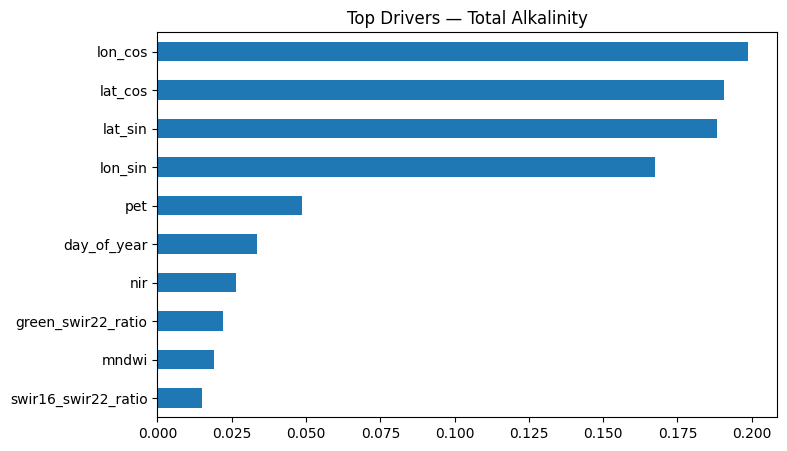

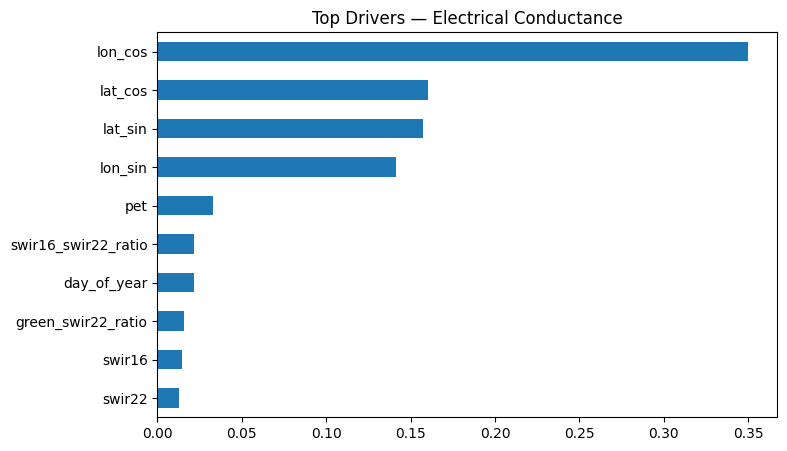

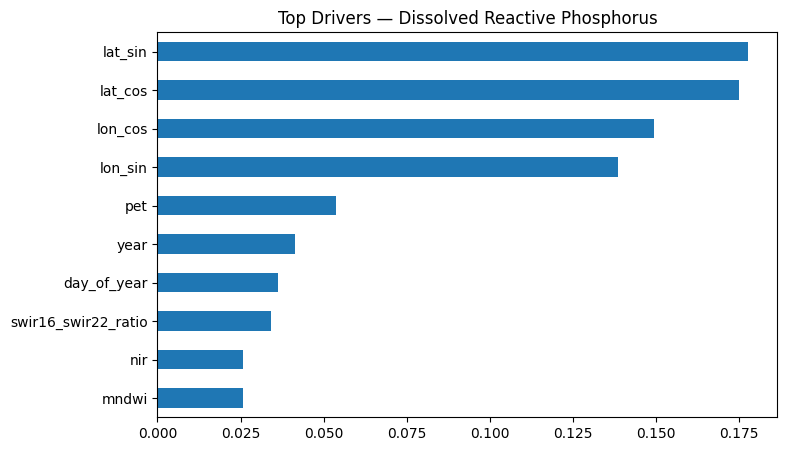

In [173]:
for target in targets:
    plot_feature_importance(
        models[target],
        f"Top Drivers — {target.replace('_', ' ').title()}"
    )


### Load Model 

In [178]:
DATA_DIR = Path("../data")
MODEL_DIR = Path("../models")


submission_df = pd.read_csv(
    DATA_DIR /r"submission_template.csv", encoding="latin1",
    
)




In [179]:


def clean_columns(df):
    df.columns = (
        df.columns.str.strip().str.lower().str.replace(" ", "_")
    )
    return df

submission_df = clean_columns(submission_df)
landsat_validation_df = clean_columns(landsat_validation_df)
terraclimate_validation_df = clean_columns(terraclimate_validation_df)

landsat_validation_df["sample_date"] = pd.to_datetime(
    landsat_validation_df["sample_date"], format="%d-%m-%Y", errors="coerce"
)

terraclimate_validation_df["sample_date"] = pd.to_datetime(
    terraclimate_validation_df["sample_date"], format="%d-%m-%Y", errors="coerce"
)


submission_df["sample_date"] = pd.to_datetime(
    submission_df["sample_date"], format="%d-%m-%Y"
)



In [180]:
submission_df.head()

,latitude,longitude,sample_date,total_alkalinity,electrical_conductance,dissolved_reactive_phosphorus
0,-32.043333,27.822778,2014-09-01,NaN,NaN,NaN
1,-33.329167,26.077500,2015-09-16,NaN,NaN,NaN
2,-32.991639,27.640028,2015-05-07,NaN,NaN,NaN
3,-34.096389,24.439167,2012-02-07,NaN,NaN,NaN
4,-32.000556,28.581667,2014-10-01,NaN,NaN,NaN


In [181]:
landsat_validation_df.head()

,latitude,longitude,sample_date,nir,green,swir16,swir22,ndmi,mndwi,landsat_missing
0,-32.043333,27.822778,2014-09-01,15229.0,12868.0,14797.0,12421.0,0.014388,-0.069727,False
1,-33.329167,26.077500,2015-09-16,NaN,NaN,NaN,NaN,NaN,NaN,True
2,-32.991639,27.640028,2015-05-07,16221.0,9304.5,12536.5,9958.0,0.128123,-0.147979,False
3,-34.096389,24.439167,2012-02-07,NaN,NaN,NaN,NaN,NaN,NaN,True
4,-32.000556,28.581667,2014-10-01,9125.0,11100.5,9455.0,8711.0,-0.017761,0.080052,False


In [182]:
terraclimate_validation_df.head()

,latitude,longitude,sample_date,pet
0,-32.043333,27.822778,2014-09-01,161.90001
1,-33.329167,26.077500,2015-09-16,177.60000
2,-32.991639,27.640028,2015-05-07,158.40001
3,-34.096389,24.439167,2012-02-07,130.00000
4,-32.000556,28.581667,2014-10-01,152.50000


In [183]:
df = submission_df.merge(
    landsat_validation_df,
    on=["latitude", "longitude", "sample_date"],
    how="left"
)

df = df.merge(
    terraclimate_validation_df,
    on=["latitude", "longitude", "sample_date"],
    how="left"
)


In [184]:
df.shape

(200, 14)

In [185]:
df["year"] = df["sample_date"].dt.year
df["month"] = df["sample_date"].dt.month
df["day_of_year"] = df["sample_date"].dt.dayofyear
df["is_wet_season"] = df["month"].isin([10,11,12,1,2,3]).astype(int)


In [186]:
df.head()

,latitude,longitude,sample_date,total_alkalinity,electrical_conductance,dissolved_reactive_phosphorus,nir,green,swir16,swir22,ndmi,mndwi,landsat_missing,pet,year,month,day_of_year,is_wet_season
0,-32.043333,27.822778,2014-09-01,NaN,NaN,NaN,15229.0,12868.0,14797.0,12421.0,0.014388,-0.069727,False,161.90001,2014,9,244,0
1,-33.329167,26.077500,2015-09-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,177.60000,2015,9,259,0
2,-32.991639,27.640028,2015-05-07,NaN,NaN,NaN,16221.0,9304.5,12536.5,9958.0,0.128123,-0.147979,False,158.40001,2015,5,127,0
3,-34.096389,24.439167,2012-02-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,130.00000,2012,2,38,1
4,-32.000556,28.581667,2014-10-01,NaN,NaN,NaN,9125.0,11100.5,9455.0,8711.0,-0.017761,0.080052,False,152.50000,2014,10,274,1


In [187]:
df["lat_rad"] = np.deg2rad(df["latitude"])
df["lon_rad"] = np.deg2rad(df["longitude"])

df["lat_sin"] = np.sin(df["lat_rad"])
df["lat_cos"] = np.cos(df["lat_rad"])
df["lon_sin"] = np.sin(df["lon_rad"])
df["lon_cos"] = np.cos(df["lon_rad"])


In [188]:
df["nir_swir16_ratio"] = df["nir"] / df["swir16"]
df["green_swir22_ratio"] = df["green"] / df["swir22"]
df["swir16_swir22_ratio"] = df["swir16"] / df["swir22"]


In [189]:
landsat_cols = ["nir", "green", "swir16", "swir22", "ndmi", "mndwi"]

df["landsat_missing"] = df[landsat_cols].isna().any(axis=1).astype(int)


In [190]:
df["pet_ndmi"] = df["pet"] * df["ndmi"]
df["pet_mndwi"] = df["pet"] * df["mndwi"]


In [191]:
df.head()

,latitude,longitude,sample_date,total_alkalinity,electrical_conductance,dissolved_reactive_phosphorus,nir,green,swir16,swir22,ndmi,mndwi,landsat_missing,pet,year,month,day_of_year,is_wet_season,lat_rad,lon_rad,lat_sin,lat_cos,lon_sin,lon_cos,nir_swir16_ratio,green_swir22_ratio,swir16_swir22_ratio,pet_ndmi,pet_mndwi
0,-32.043333,27.822778,2014-09-01,NaN,NaN,NaN,15229.0,12868.0,14797.0,12421.0,0.014388,-0.069727,0,161.90001,2014,9,244,0,-0.559262,0.485599,-0.530560,0.847647,0.466738,0.884395,1.029195,1.035987,1.191289,2.329341,-11.288817
1,-33.329167,26.077500,2015-09-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,177.60000,2015,9,259,0,-0.581704,0.455138,-0.549448,0.835528,0.439586,0.898200,NaN,NaN,NaN,NaN,NaN
2,-32.991639,27.640028,2015-05-07,NaN,NaN,NaN,16221.0,9304.5,12536.5,9958.0,0.128123,-0.147979,0,158.40001,2015,5,127,0,-0.575813,0.482409,-0.544517,0.838750,0.463915,0.885880,1.293902,0.934374,1.258938,20.294700,-23.439807
3,-34.096389,24.439167,2012-02-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,130.00000,2012,2,38,1,-0.595094,0.426544,-0.560587,0.828096,0.413727,0.910401,NaN,NaN,NaN,NaN,NaN
4,-32.000556,28.581667,2014-10-01,NaN,NaN,NaN,9125.0,11100.5,9455.0,8711.0,-0.017761,0.080052,0,152.50000,2014,10,274,1,-0.558515,0.498844,-0.529927,0.848043,0.478411,0.878136,0.965098,1.274308,1.085409,-2.708558,12.207864


In [192]:
feature_cols = [
    "year", "month", "day_of_year", "is_wet_season",
    "lat_sin", "lat_cos", "lon_sin", "lon_cos",
    "nir", "green", "swir16", "swir22",
    "ndmi", "mndwi",
    "nir_swir16_ratio", "green_swir22_ratio", "swir16_swir22_ratio",
    "pet", "pet_ndmi", "pet_mndwi",
    "landsat_missing"
]

X_submit = df[feature_cols]


### Load Trained Model

In [193]:
targets = [
    "total_alkalinity",
    "electrical_conductance",
    "dissolved_reactive_phosphorus"
]

models = {
    target: joblib.load(MODEL_DIR / f"rf_{target}.pkl")
    for target in targets
}


In [194]:
for target in targets:
    df[target] = models[target].predict(X_submit)


In [195]:
submission_output = df[
    ["latitude", "longitude", "sample_date"] + targets
]

submission_output["sample_date"] = submission_output[
    "sample_date"
].dt.strftime("%d-%m-%Y")


In [196]:
submission_output.head()


,latitude,longitude,sample_date,total_alkalinity,electrical_conductance,dissolved_reactive_phosphorus
0,-32.043333,27.822778,01-09-2014,101.586876,265.300938,21.729359
1,-33.329167,26.077500,16-09-2015,237.802679,709.756662,74.253525
2,-32.991639,27.640028,07-05-2015,64.423697,269.566349,34.674554
3,-34.096389,24.439167,07-02-2012,44.961424,825.553875,11.720811
4,-32.000556,28.581667,01-10-2014,90.709203,240.249586,23.745405


In [197]:
OUTPUT_DIR = Path("../data")
OUTPUT_DIR.mkdir(exist_ok=True)

submission_output.to_csv(
    OUTPUT_DIR / "RiverIQ_submission.csv",
    index=False
)
